In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
# Constants
G = 6.67430e-11            # gravitational constant, m^3 kg^-1 s^-2
M_earth = 5.972e24         # mass of Earth in kg
R_earth = 6.371e6          # radius of Earth in meters


## 🚀 Rocket Simulation


### Newton's Law of Gravitation:

$ \vec{F} = -\frac{GMm}{r^{2}}\hat{r}$

where:

$G$ is Newton's Gravitational Constant, 

$M$ is the mass of the Earth, 

$m$ is the mass of the projectile, 

$r$ is the distance from Earth's centre. 


### Newton's Second Law:

$ \vec{a} = \frac{\vec{F}}{m} = -\frac{GM}{r^{2}}\hat{r}$

The acceleration of the projectile therefore is idependent of its mass. 

### Equations of motion:


$ \frac{d\vec{r}}{dt} = \vec{v},  \frac{d\vec{v}}{dt} = -\frac{GM}{r^{3}}\hat{r}$


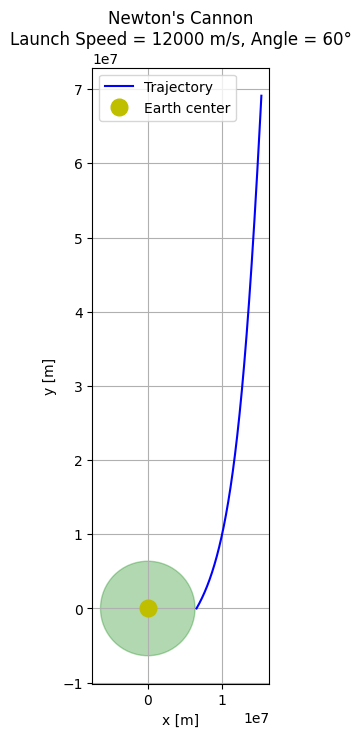

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.003e+00 ...  9.995e+03  1.000e+04]
        y: [[ 6.571e+06  6.601e+06 ...  1.532e+07  1.532e+07]
            [ 0.000e+00  5.199e+04 ...  6.909e+07  6.912e+07]
            [ 6.000e+03  5.954e+03 ...  3.014e+02  3.013e+02]
            [ 1.039e+04  1.039e+04 ...  5.819e+03  5.818e+03]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 254
     njev: 0
      nlu: 0

In [53]:

# Time span
t_max = 1000000  # seconds
t_eval = np.linspace(0, t_max, 2000)

# Define a separate event function
def hit_earth_event(t, y, G, M):
    r = np.sqrt(y[0]**2 + y[1]**2)
    return r - R_earth  # triggers when r = R_earth

hit_earth_event.terminal = True  # stop the integration
hit_earth_event.direction = -1   # only trigger when approaching Earth

def cannon(t, y, G, M):  # Function defining Newton's 2nd law as a system of ODEs
    rx, ry, vx, vy = y 
    r = np.sqrt(rx**2 + ry**2)
    ax = -G * M * rx / r**3
    ay = -G * M * ry / r**3
    return [vx, vy, ax, ay]




def simulate_cannon(altitude, launch_angle_deg, launch_speed, t_max=10000):
    theta = np.radians(launch_angle_deg)
    r0 = R_earth + altitude
    x0, y0 = r0, 0
    vx = launch_speed * np.cos(theta)
    vy = launch_speed * np.sin(theta)
    y_init = [x0, y0, vx, vy]
    t_eval = np.linspace(0, t_max, 2000)

    sol = solve_ivp(
        cannon, [0, t_max], y_init, t_eval=t_eval,
        args=(G, M_earth), rtol=1e-8, events=hit_earth_event
    )

    x = sol.y[0]  # x position determined by the ODE solver
    y = sol.y[1]  # y position determined by the ODE solver

    # Plot the result
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(x, y, label="Trajectory", color='blue')
    ax.plot(0, 0, 'yo', markersize=12, label="Earth center")

    # Draw Earth
    earth = plt.Circle((0, 0), R_earth, color='green', alpha=0.3)
    ax.add_patch(earth)# Define a separate event function

    ax.set_aspect('equal')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(f"Newton's Cannon\nLaunch Speed = {launch_speed} m/s, Angle = {launch_angle_deg}°")
    ax.grid(True)
    ax.legend()
    plt.show()

    return sol

simulate_cannon(200000, 60, 12000)


Exercise ideas:

- Vary initial conditions - play around with it
- Escape velocity (make a function defining it - ask students to verify)
- Plotting energy over time (KE, PE)
- Introduction air resistance, and compare plots?
- Circular orbits

It may be useful for us to calculate the minmimum speed needed for the projectile to escape Earth's gravity. 

The total energy $E$ of the projectile is the sum of its Potential and Kinetic Energy, i.e:

$E = \frac{1}{2}mv^{2}-\frac{GMm}{r}$

where $r$ is the distance from the Earth's centre and $v$ is the speed at distance $r$. 

At the escape velocity $v_{esc}$, the kinetic energy is equal to the potential energy of the Earth.

$\frac{1}{2}mv_{esc}^{2}=\frac{GMm}{r}$

where $m$ can cancel out:

$\frac{1}{2}v_{esc}^{2}=\frac{GM}{r}$

and we can rearragne for v_{esc}:

$ v_{esc} = \sqrt{\frac{2GM}{r}}$

Ex. implement this equation into the function below. How can you test whether this equation works or not. 

In [46]:
def escape_velocity(r):
    return np.sqrt(2 * G * M_earth / r)


altitude = 200000  # altitude in meters

In [47]:
r_launch = R_earth + altitude
v_esc = escape_velocity(r_launch)
print(f"Escape velocity at {altitude} m altitude: {v_esc:.2f} m/s")


Escape velocity at 200000 m altitude: 11014.43 m/s


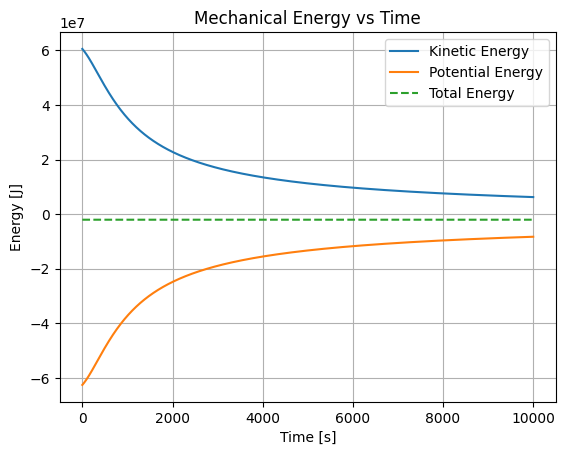

In [56]:
m = 1

vx = sol.y[2]
vy = sol.y[3]
r = np.sqrt(sol.y[0]**2 + sol.y[1]**2)

KE = 0.5 * m * (vx**2 + vy**2)
PE = -G * M_earth * m / r
E_total = KE + PE

plt.figure()
plt.plot(sol.t, KE, label="Kinetic Energy")
plt.plot(sol.t, PE, label="Potential Energy")
plt.plot(sol.t, E_total, label="Total Energy", linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel("Energy [J]")
plt.title("Mechanical Energy vs Time")
plt.grid(True)
plt.legend()
plt.show()


Air resistance:

$\vec{F}_{drag} = -\frac{1}{2}C_{d}\rho A\vec{v}$

$\vec{a}_{drag} = \frac{\vec{F}_{drag}}{m}$


In [64]:
def hit_earth_event(t, y, *args):  # Accept variable args
    r = np.sqrt(y[0]**2 + y[1]**2)
    return r - R_earth

hit_earth_event.terminal = True
hit_earth_event.direction = -1

def simulate_cannon_with_drag(altitude, launch_angle_deg, launch_speed, t_max=10000,
                               C_d=0.47, rho=1.225, A=0.01, mass=1.0):
    """
    Simulate Newton's cannon with air resistance (drag force).
    """


    # Convert angle and initial position
    theta = np.radians(launch_angle_deg)
    r0 = R_earth + altitude
    x0, y0 = r0, 0

    # Initial velocity components
    vx = launch_speed * np.cos(theta)
    vy = launch_speed * np.sin(theta)

    # Initial state vector
    y_init = [x0, y0, vx, vy]
    t_eval = np.linspace(0, t_max, 2000)

    # ODE function with drag
    def cannon_with_drag(t, y, G, M, C_d, rho, A, m):
        rx, ry, vx, vy = y
        r = np.sqrt(rx**2 + ry**2)
        v = np.sqrt(vx**2 + vy**2)

        # Gravitational acceleration
        ax_g = -G * M * rx / r**3
        ay_g = -G * M * ry / r**3

        # Drag acceleration
        ax_d = -0.5 * C_d * rho * A * v * vx / m
        ay_d = -0.5 * C_d * rho * A * v * vy / m

        # Total acceleration
        ax = ax_g + ax_d
        ay = ay_g + ay_d

        return [vx, vy, ax, ay]


    # Solve the motion
    sol = solve_ivp(
        cannon_with_drag,
        [0, t_max],
        y_init,
        t_eval=t_eval,
        args=(G, M_earth, C_d, rho, A, mass),
        rtol=1e-8,
        events=hit_earth_event
    )

    x = sol.y[0]
    y = sol.y[1]

    # Plot trajectory
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(x, y, label="Trajectory with air resistance", color='red')
    ax.plot(0, 0, 'yo', markersize=12, label="Earth center")

    # Earth outline
    earth = plt.Circle((0, 0), R_earth, color='green', alpha=0.3)
    ax.add_patch(earth)

    ax.set_aspect('equal')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(f"Newton's Cannon with Air Resistance\nSpeed = {launch_speed} m/s, Angle = {launch_angle_deg}°")
    ax.grid(True)
    ax.legend()
    plt.show()

    return sol


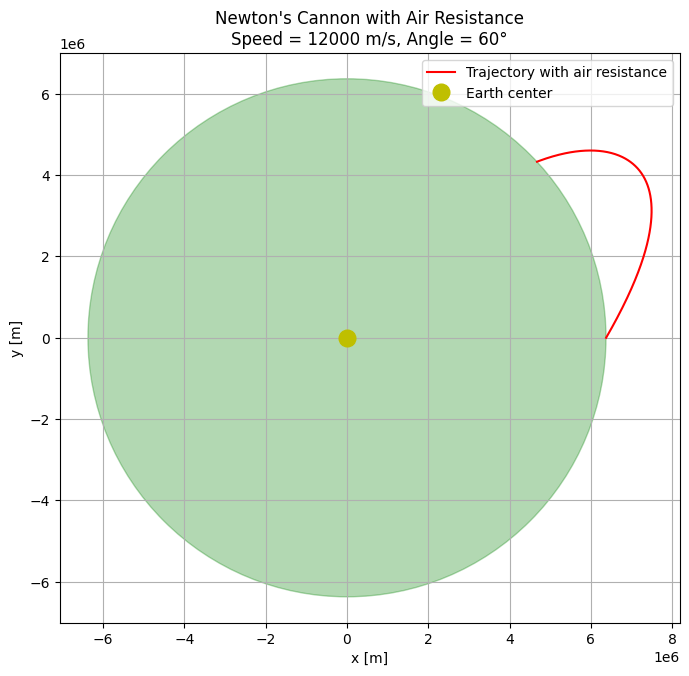

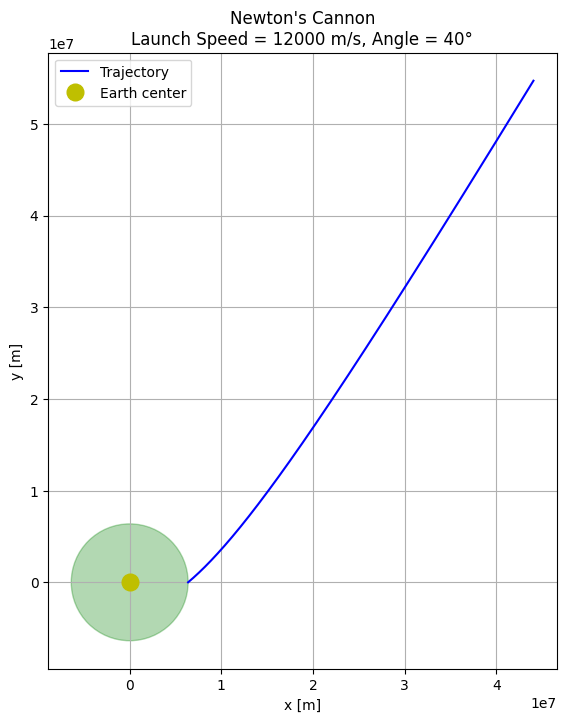

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.003e+00 ...  9.995e+03  1.000e+04]
        y: [[ 6.373e+06  6.419e+06 ...  4.402e+07  4.403e+07]
            [ 0.000e+00  3.859e+04 ...  5.468e+07  5.470e+07]
            [ 9.193e+03  9.144e+03 ...  2.877e+03  2.876e+03]
            [ 7.713e+03  7.713e+03 ...  4.690e+03  4.690e+03]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 230
     njev: 0
      nlu: 0

In [81]:
simulate_cannon_with_drag(
    altitude=2000,
    launch_angle_deg=60,
    launch_speed=12000,
    t_max=10000,
    C_d=0.47,        # drag coefficient
    rho=1.1,       # air density at sea level
    A=0.01,          # cross-sectional area in m²
    mass=10000.0         # mass in kg
)

simulate_cannon(2000, 40, 12000)
